# Importing Packages

In [11]:
import pandas as pd
import numpy as np
import csv
from scipy import stats
import re
import string
import os, json
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
import nltk
import itertools
from collections import Counter, defaultdict
import string
from nltk.corpus import stopwords, words
from wordcloud import WordCloud, STOPWORDS

from IPython.display import Image

%matplotlib inline

# Loading Data

In [484]:
## count daily educational COVID Tweets from four phases 
filename=['2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08', '2020-05-09',
         '2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12',
          '2021-09-05', '2021-09-06', '2021-09-07', '2021-09-08', '2021-09-09', '2021-09-10', '2021-09-11', 
         '2022-09-04', '2022-09-05', '2022-09-06', '2022-09-07', '2022-09-08', '2022-09-09', '2022-09-10']
dailycount=dict()
for file in filename: 
    df = pd.DataFrame()
    with open(f'./data/full_daily_json/{file}_full.json', "r") as f:
        for line in f.readlines():
            result=json.loads(line)
            l = [result]
            df = df.append(pd.DataFrame(l), sort=True)
    dailycount[file] = len(df)

In [490]:
## Load daily educational COVID Tweets

def get_daily_tweets(date): 
    df = pd.DataFrame()
    with open(f'./data/full_daily_json/{date}_full.json', "r") as f:
        for line in f.readlines():
            result=json.loads(line)
            l = [result]
            df = df.append(pd.DataFrame(l), sort=True)
    return df['full_text'].to_numpy()
daily_tweets = dict()
for file in filename: 
    daily_tweets[file] = get_daily_tweets(file)

In [12]:
## Load educational COVID Tweets from each phase 
period1data=pd.read_excel('./data/period1_full.xlsx')  
period2data=pd.read_excel('./data/period2_full.xlsx')  
period3data=pd.read_excel('./data/period3_full.xlsx')  
period4data=pd.read_excel('./data/period4_full.xlsx')  

In [16]:
## Count the number of educational COVID Tweets from each phase 
## and compute their percentages out of COVID Tweets
def countdata(period): 
    countFile = 100000
    print("Number of educational tweets:",len(period))
    print("Percentage of educational tweets: {:.2%}".format(len(period)/countFile))
    
period1count=countdata(period1data)
period2count=countdata(period2data)
period3count=countdata(period3data)
period4count=countdata(period4data) 

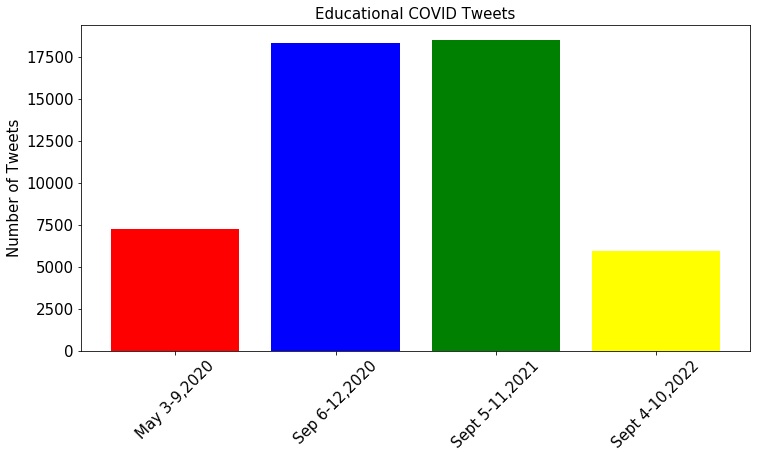

In [67]:
#bar visualization of numbers of Tweets from four phases 
available_periods = [period1data, period2data, period3data, period4data]
count = [len(df) for df in available_periods]
    
labels = ['May 3-9,2020', 'Sep 6-12,2020', 'Sept 5-11,2021', 'Sept 4-10,2022']
bar_fig = plt.figure(figsize = (12,6))
_ = plt.bar(x = range(1,5), 
            height = count, 
            tick_label = labels,  color=['red', 'blue', 'green', 'yellow']) 
plt.tick_params(labelsize = 15)
_ = plt.xticks(rotation = 45)
_ = plt.title("Educational COVID Tweets", fontsize = 15)
_ = plt.ylabel("Number of Tweets", fontsize = 15)

In [19]:
period1_tweets, period2_tweets, period3_tweets, period4_tweets = period1data['full_text'], period2data['full_text'], period3data['full_text'], period4data['full_text'] 

In [21]:
period1_tweets_withoutURL = []
for tweet in period1data['full_text']: 
    period1_tweets_withoutURL.append(re.sub(r"http\S+", "", str(tweet)))

In [22]:
period2_tweets_withoutURL = []
for tweet in period2data['full_text']: 
    period2_tweets_withoutURL.append(re.sub(r"http\S+", "", str(tweet)))

In [23]:
period3_tweets_withoutURL = []
for tweet in period3data['full_text']: 
    period3_tweets_withoutURL.append(re.sub(r"http\S+", "", str(tweet)))

In [24]:
period4_tweets_withoutURL = []
for tweet in period4data['full_text']: 
    period4_tweets_withoutURL.append(re.sub(r"http\S+", "", str(tweet)))

In [25]:
#Data frame to dict

tweets = {'period1': period1_tweets.to_numpy(), 
          'period2': period2_tweets.to_numpy(), 
          'period3': period3_tweets.to_numpy(), 
          'period4': period4_tweets.to_numpy()}

In [26]:
tweets_with_time = {'period1': list(zip(period1data['created_at'], period1_tweets_withoutURL)), 
                    'period2': list(zip(period2data['created_at'], period2_tweets_withoutURL)), 
                    'period3': list(zip(period3data['created_at'], period3_tweets_withoutURL)),
                    'period4': list(zip(period4data['created_at'], period4_tweets_withoutURL))}

In [27]:
## download nltk 
nltk.download('stopwords')
nltk.download('words')
tokenizer = RegexpTokenizer(r'\w+')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yiyunfan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/yiyunfan/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
## tokenize words by period 
wordsByPeriod = defaultdict(list)

for i in tweets:
    tokens = []
    for j,tweet in enumerate(tweets[i]):
        token = tokenizer.tokenize(tweets[i][j])
        tokens.append(token)
    wordsByPeriod[i] = tokens

In [30]:
## list stop words for removal 
stop_words = set(stopwords.words('english'))
englishWords = set([x for x in words.words()])
englishWordsDict = defaultdict(lambda: "Not Present")
for i in englishWords:
    englishWordsDict[i] = True

In [33]:
## Count and rank words (non-stop-words) used in educational Tweets from each phase 
wordsCounterByPeriod = defaultdict(dict)
wordCloudByPeriod = {}
for period in wordsByPeriod:
    wordCounter = Counter()
    cloudWord = ''
    for token in wordsByPeriod[period]:
        filteredList = []
        for word in token:
            word = word.lower()
            if word in string.punctuation:
                continue
            if word in stop_words:
                continue
            if englishWordsDict[word] == True:
                wordCounter[word.lower()] += 1
                filteredList.append(word.lower())
        cloudWord += " ".join(filteredList)+" "
    wordCloudByPeriod[period] = cloudWord
    wordsCounterByPeriod[period] = wordCounter

(None, None, None, None)

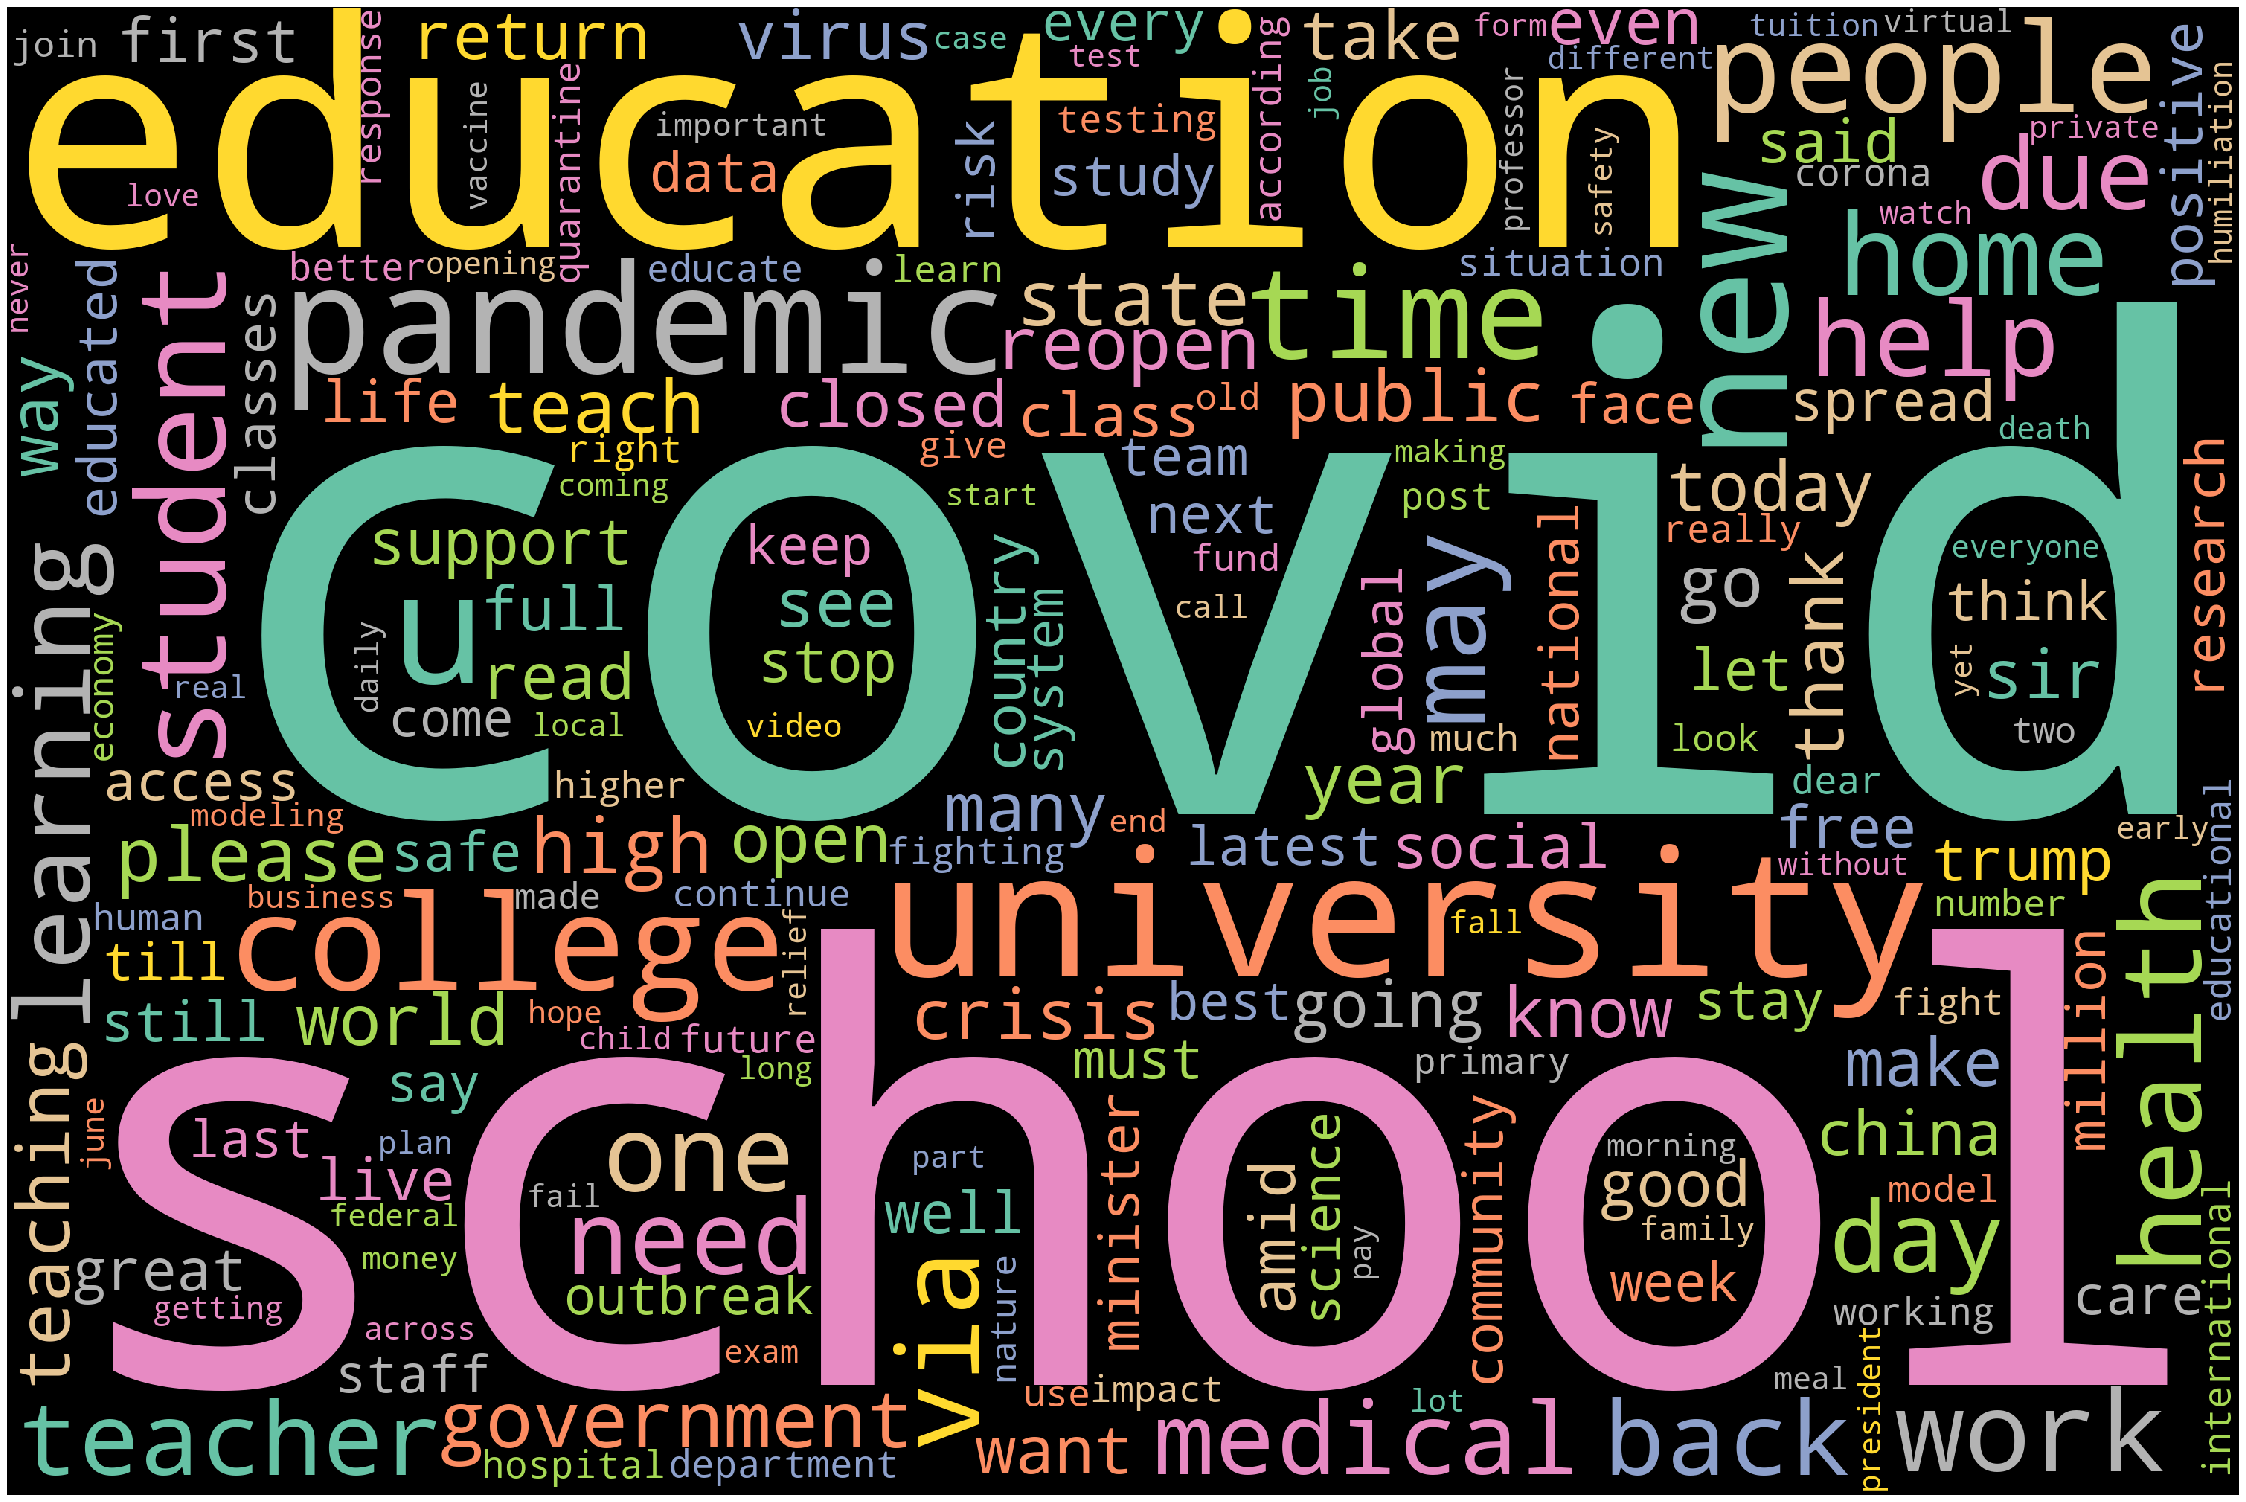

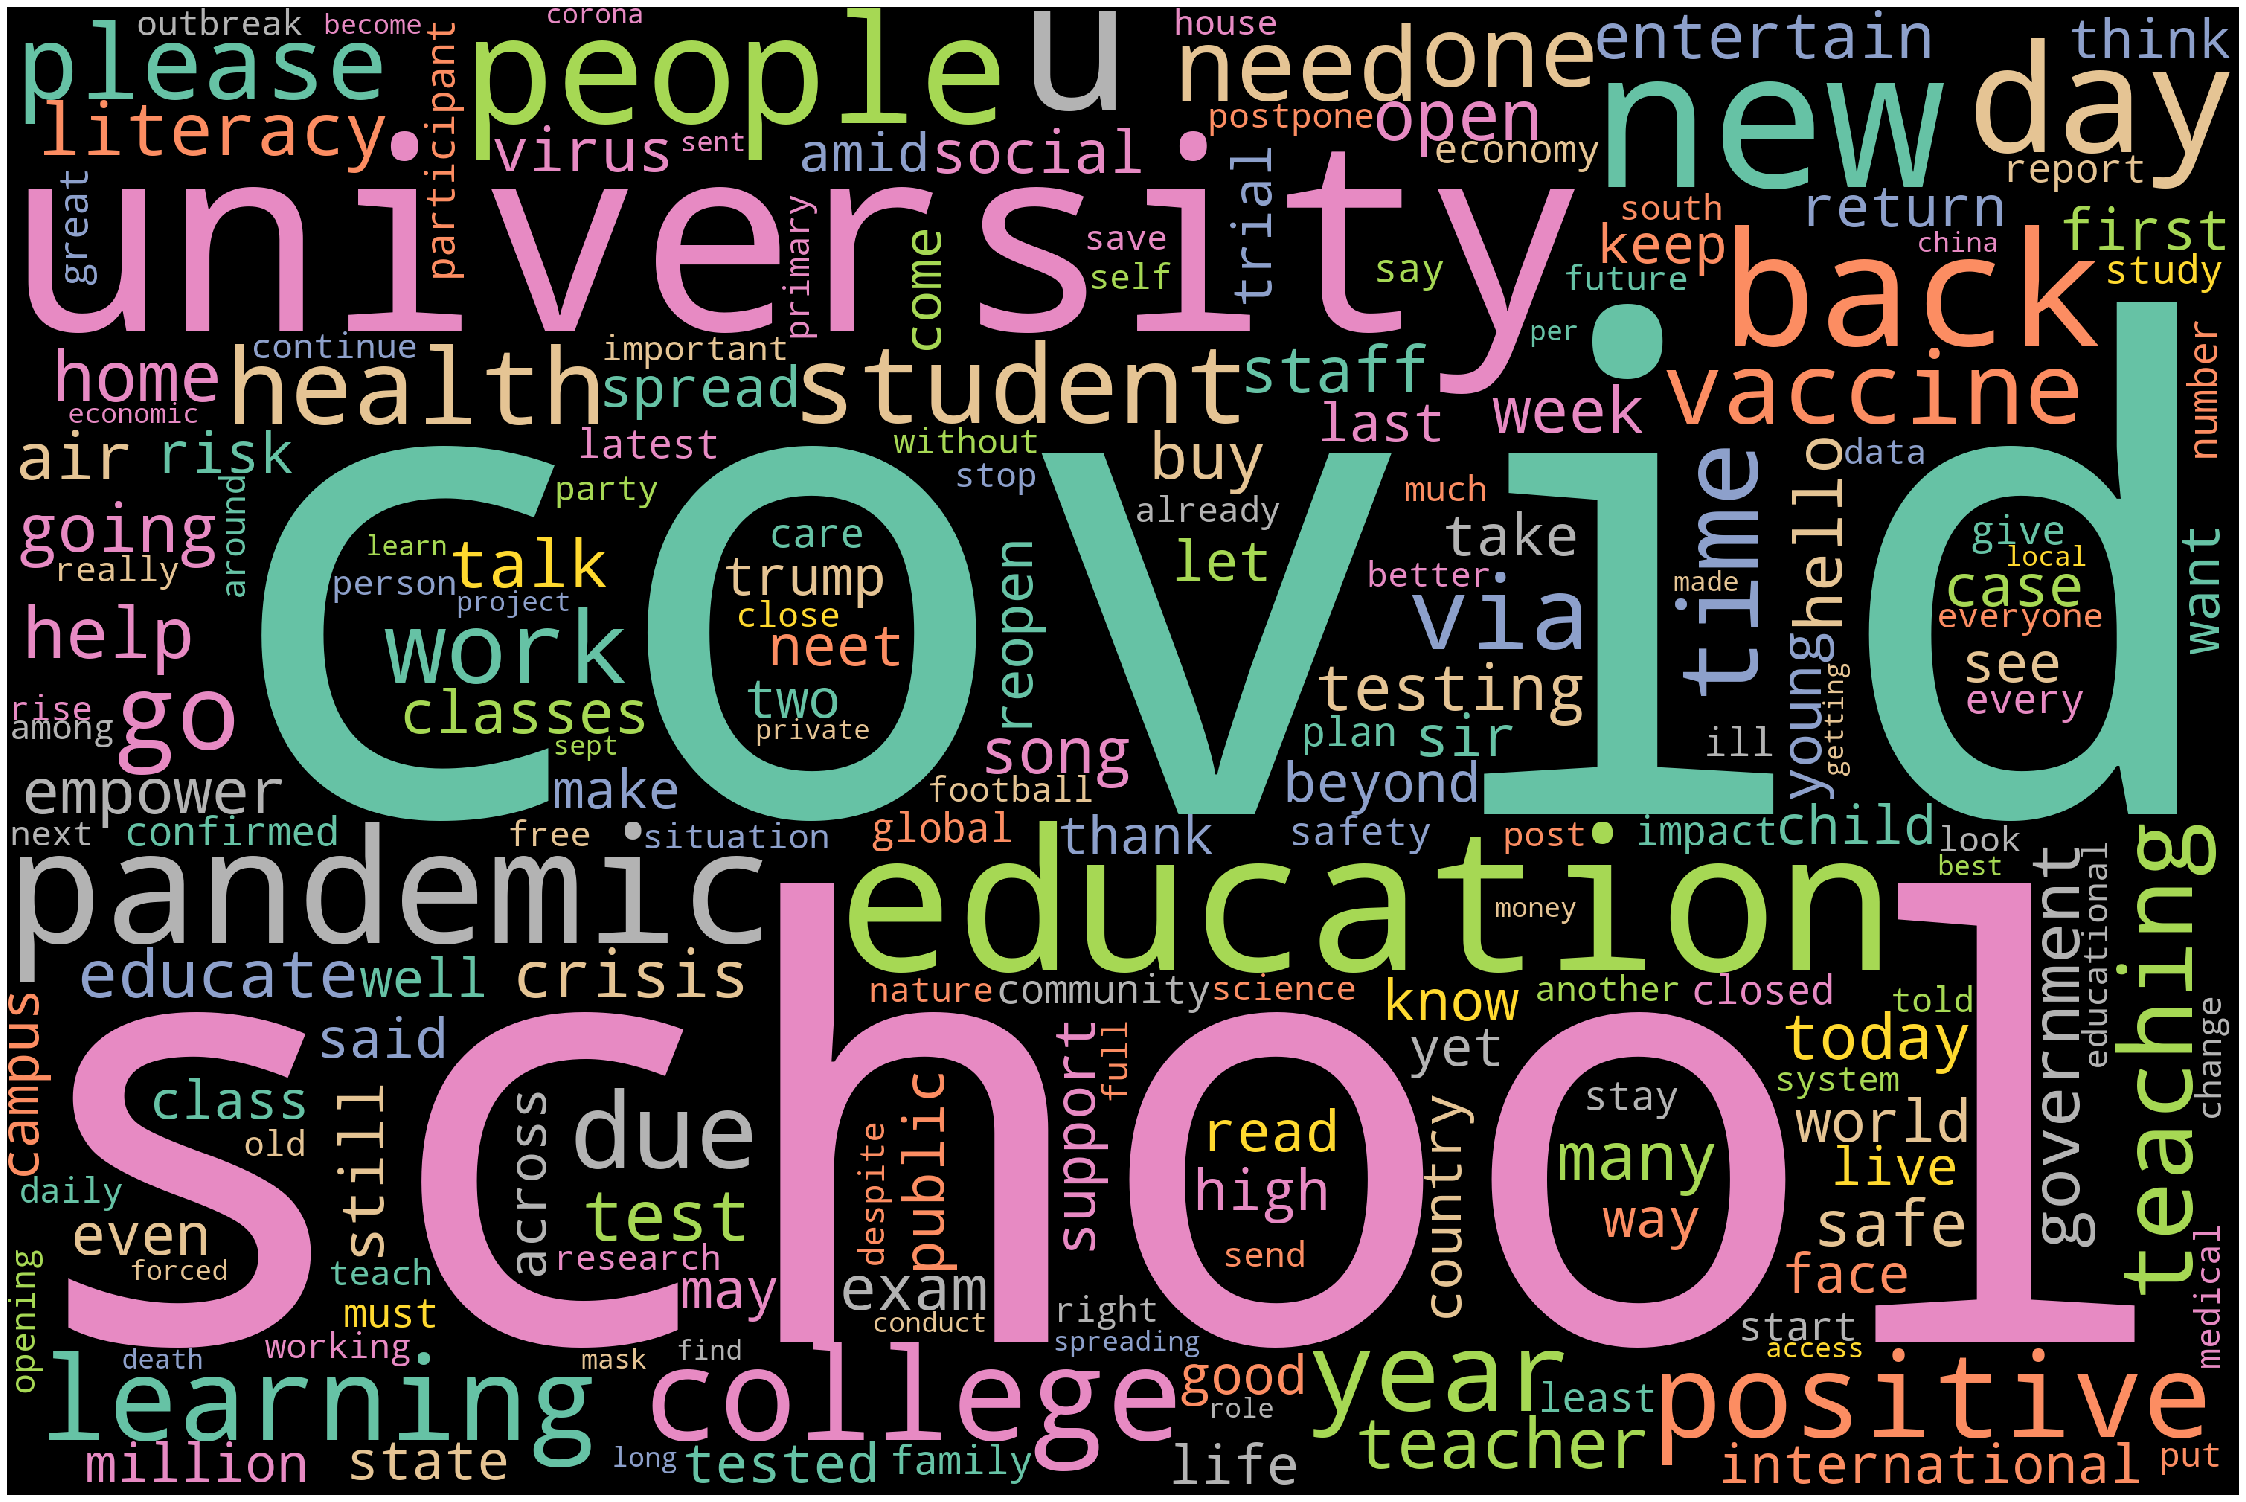

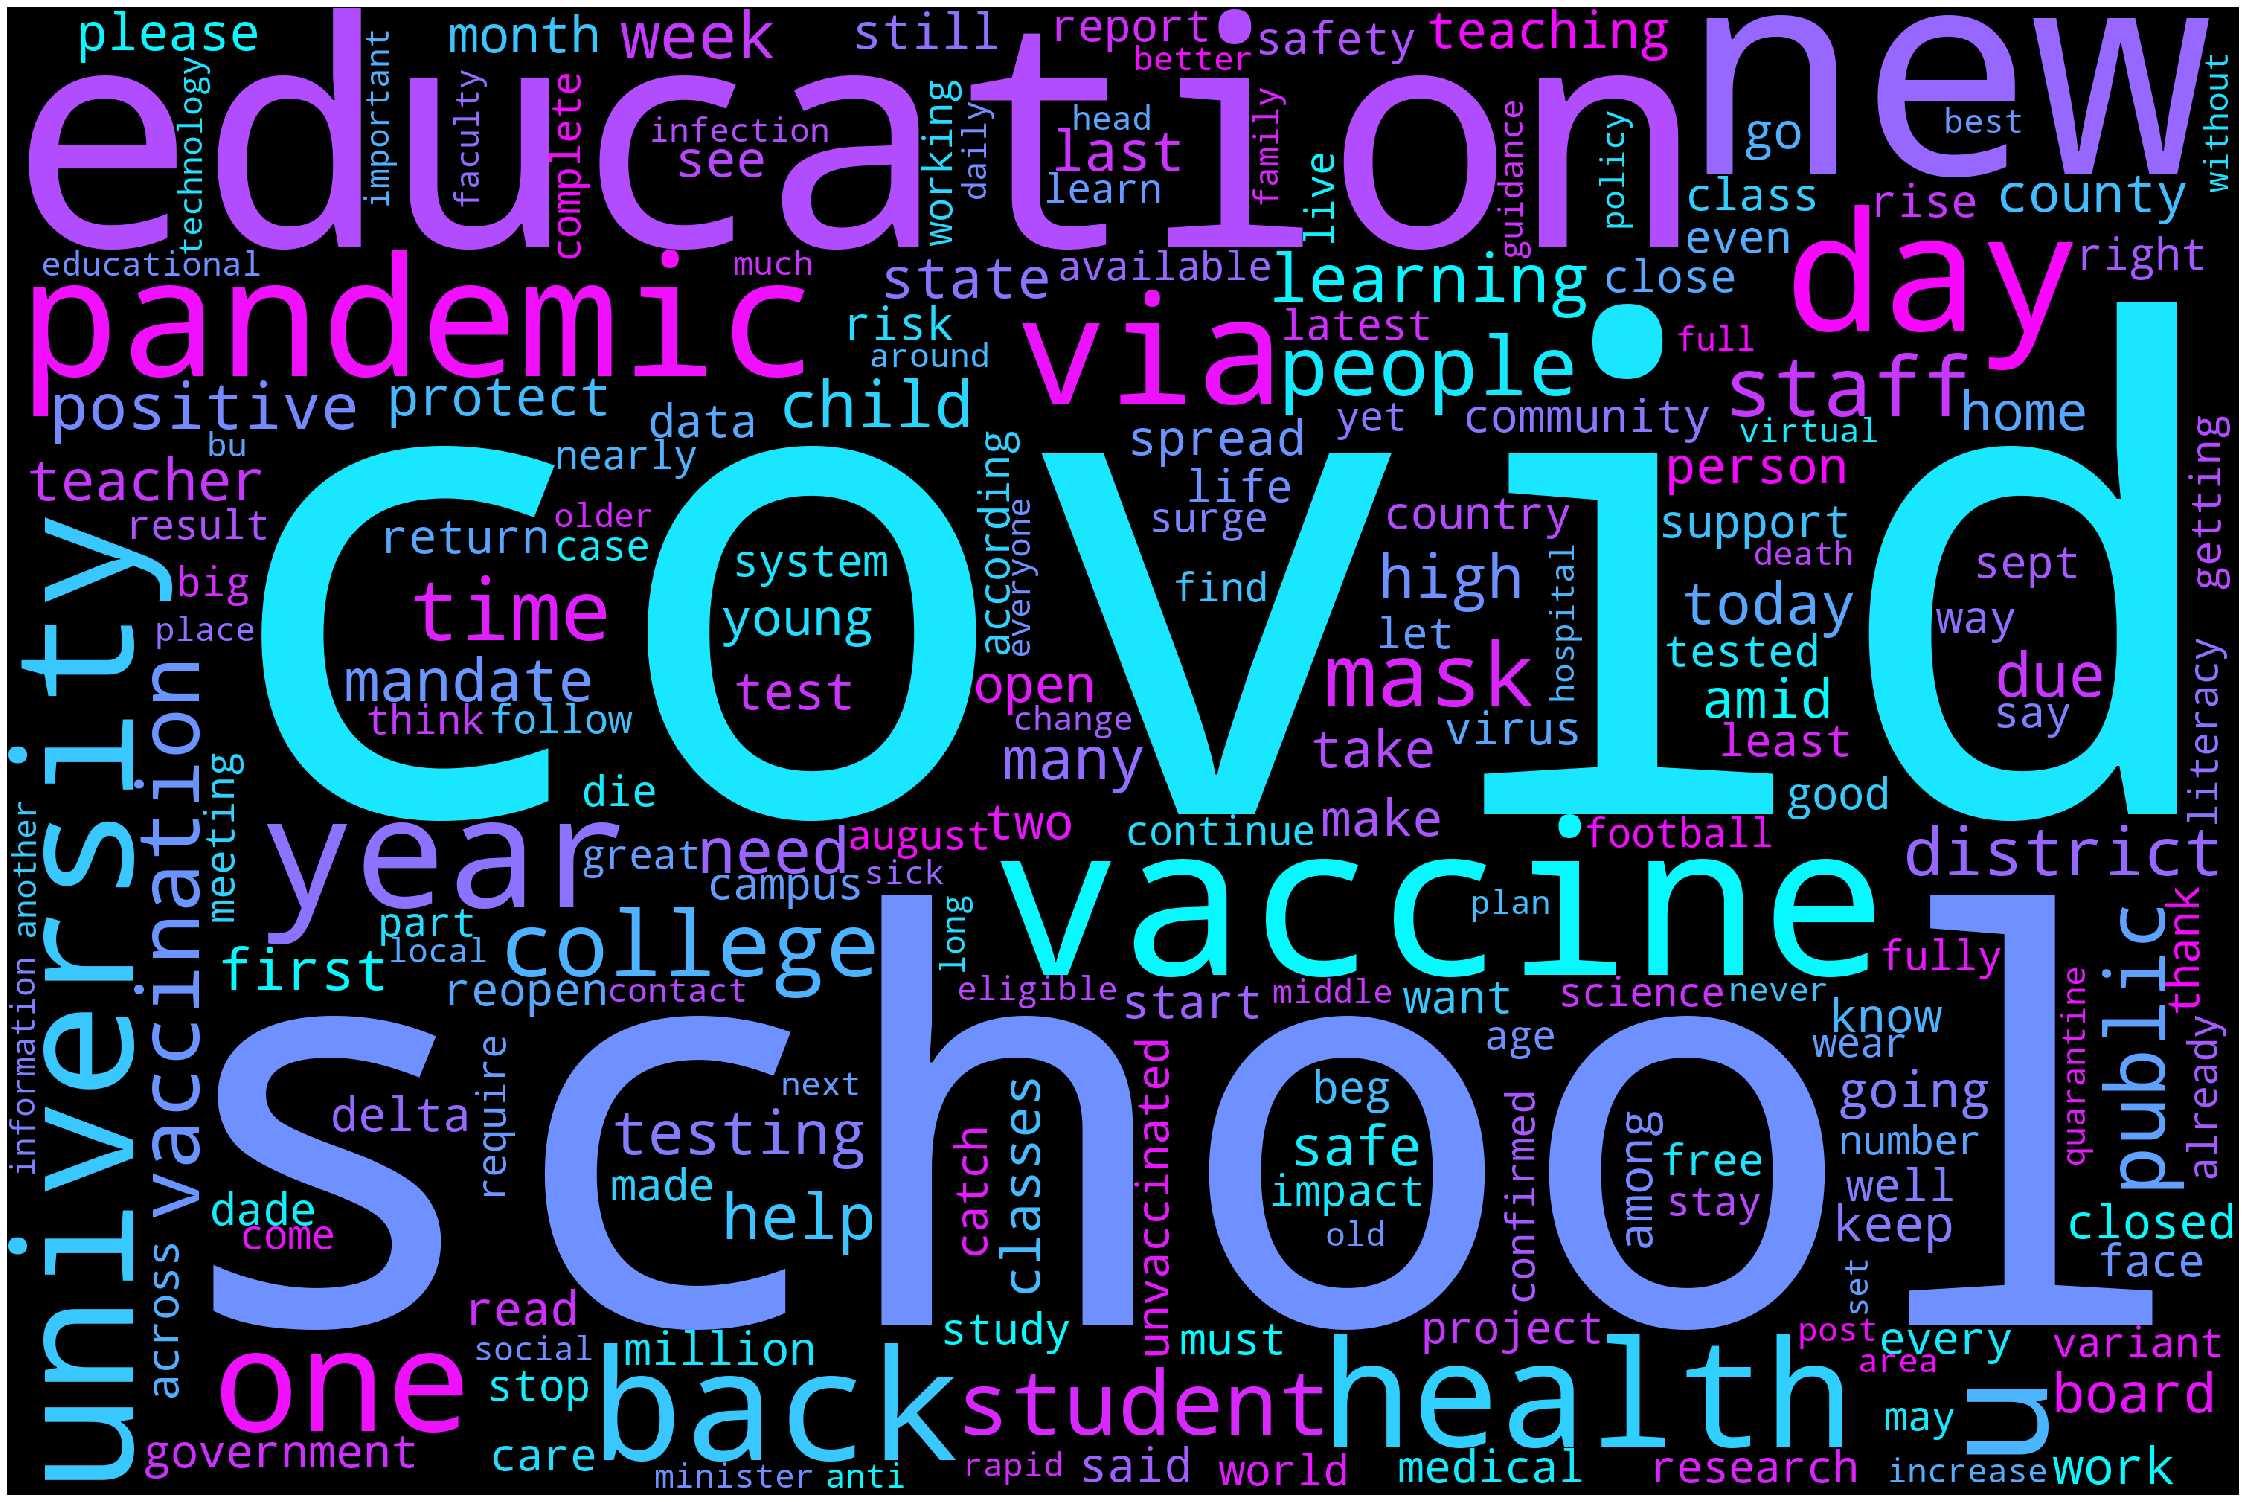

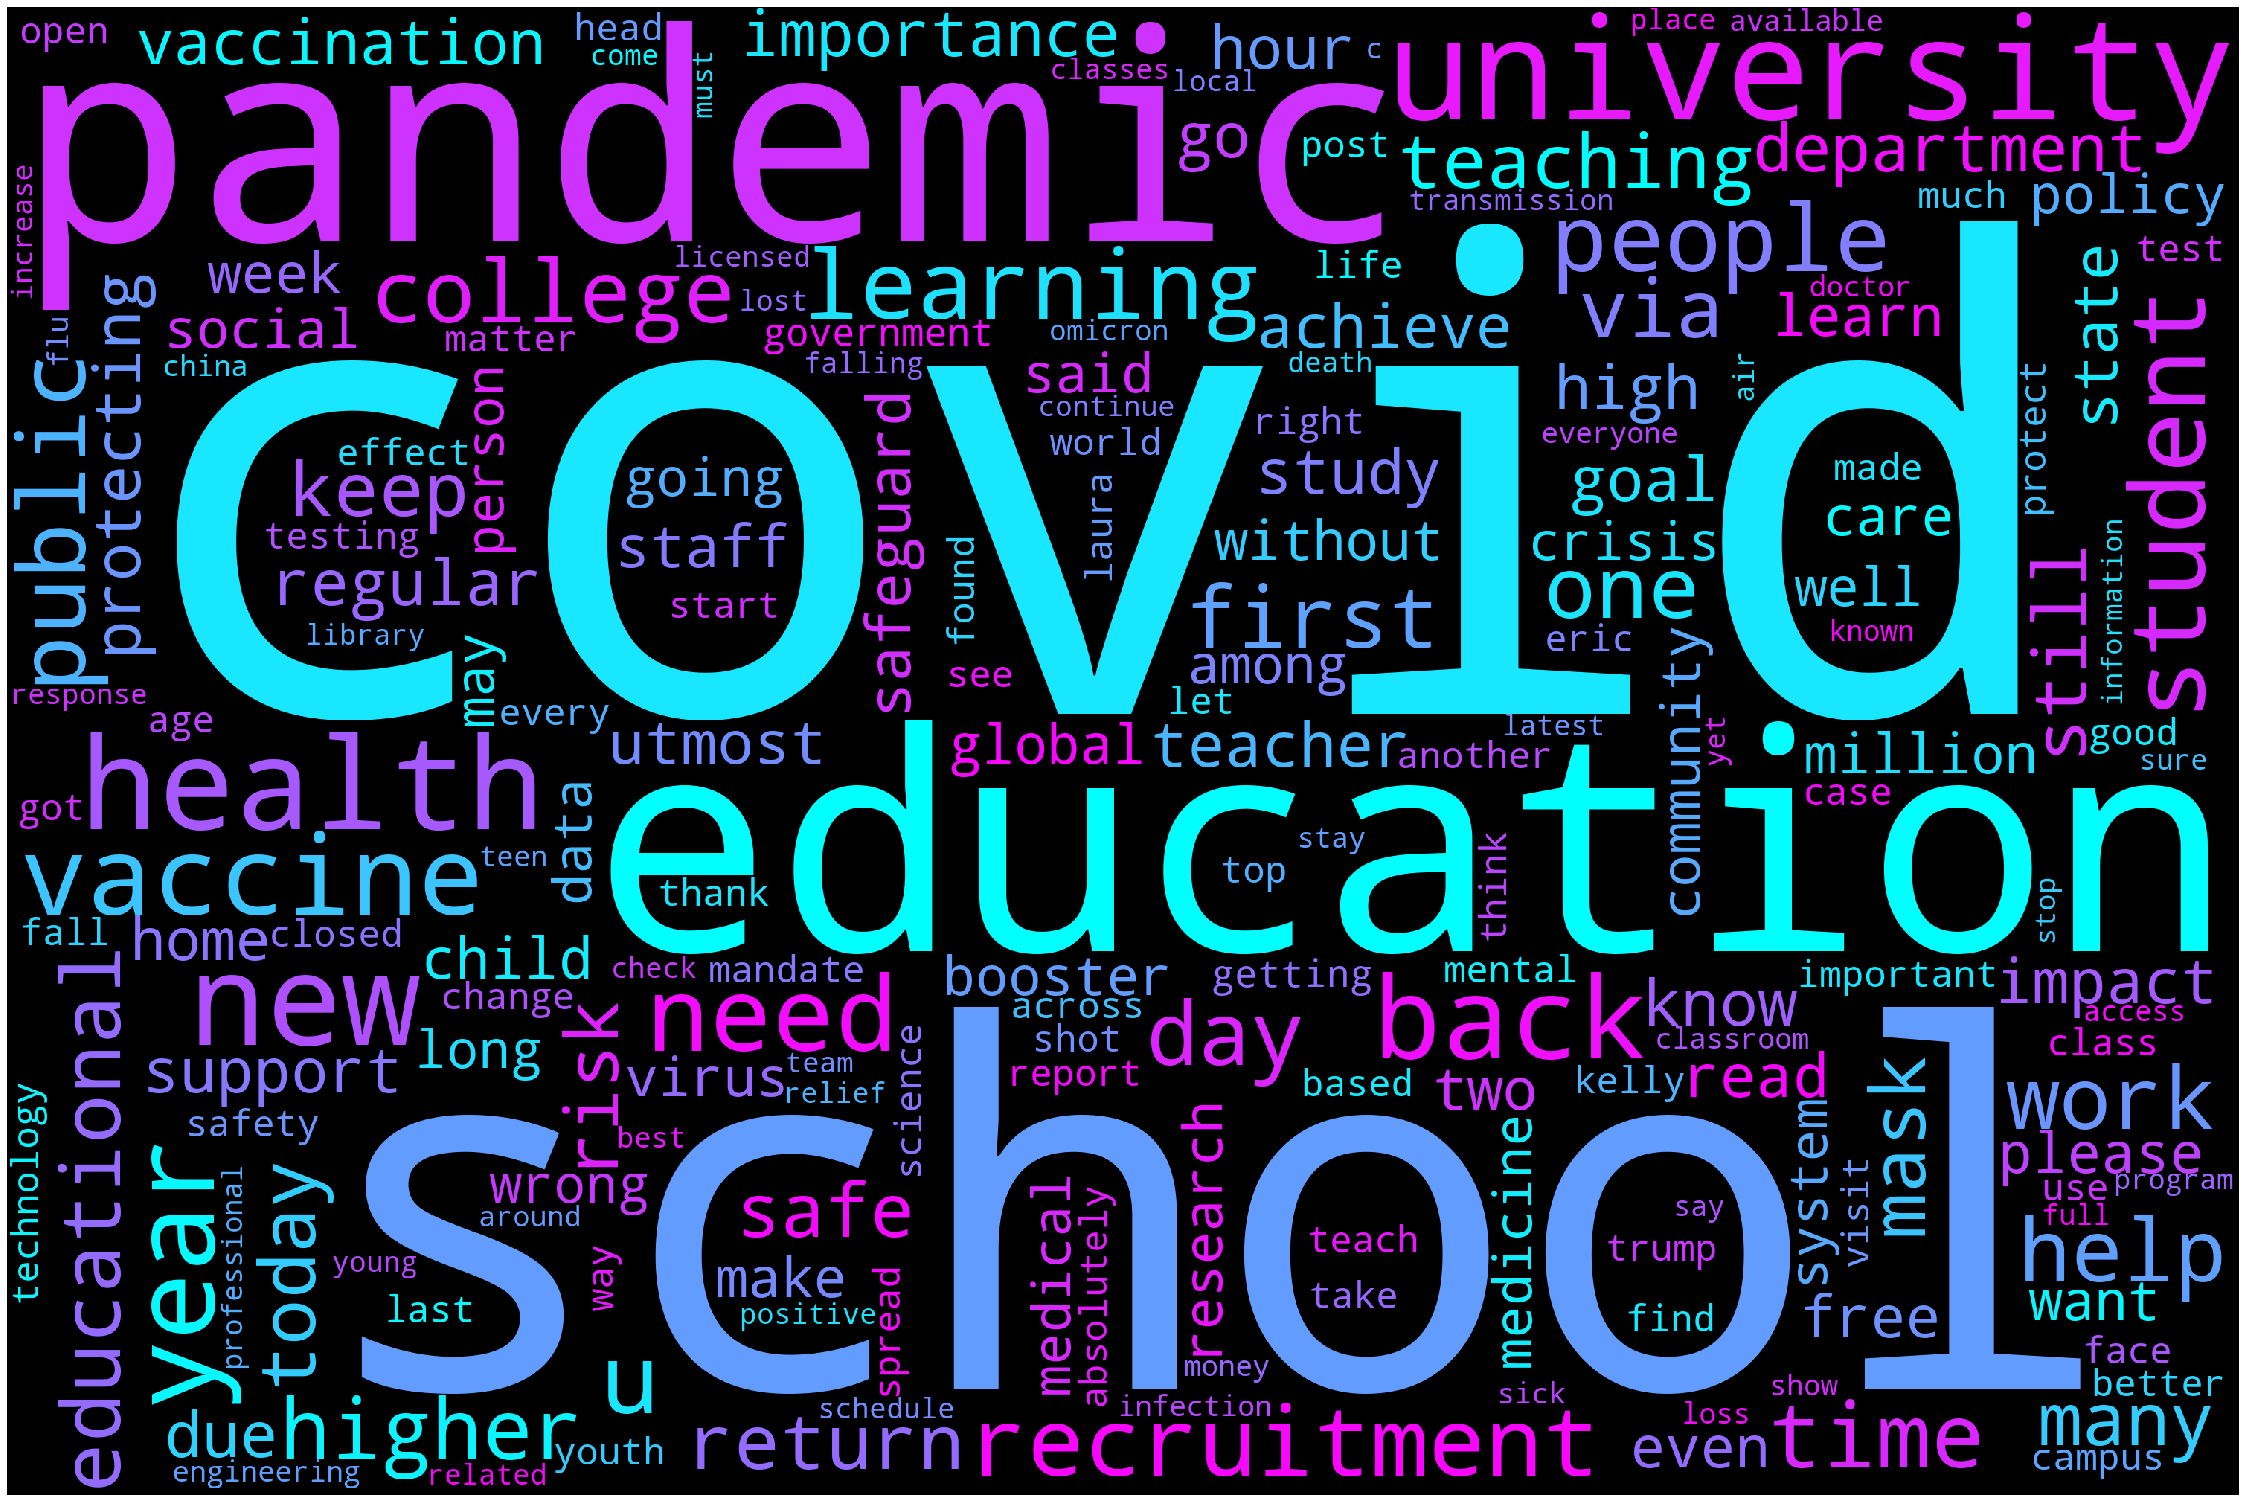

In [43]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

# Generate word cloud for each phase 
peroid1_wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(wordCloudByPeriod['period1'])
peroid2_wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(wordCloudByPeriod['period2'])
period3_wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='cool', collocations=False, stopwords = STOPWORDS).generate(wordCloudByPeriod['period3'])
period4_wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='cool', collocations=False, stopwords = STOPWORDS).generate(wordCloudByPeriod['period4'])

# Plot
plot_cloud(peroid1_wordcloud), plot_cloud(peroid2_wordcloud), plot_cloud(period3_wordcloud), plot_cloud(period4_wordcloud)

In [41]:
## load data from all phases 
all_data = pd.concat([period1data, period2data, period3data, period4data], ignore_index=True)

# Concated Word Cloud from all Phases 

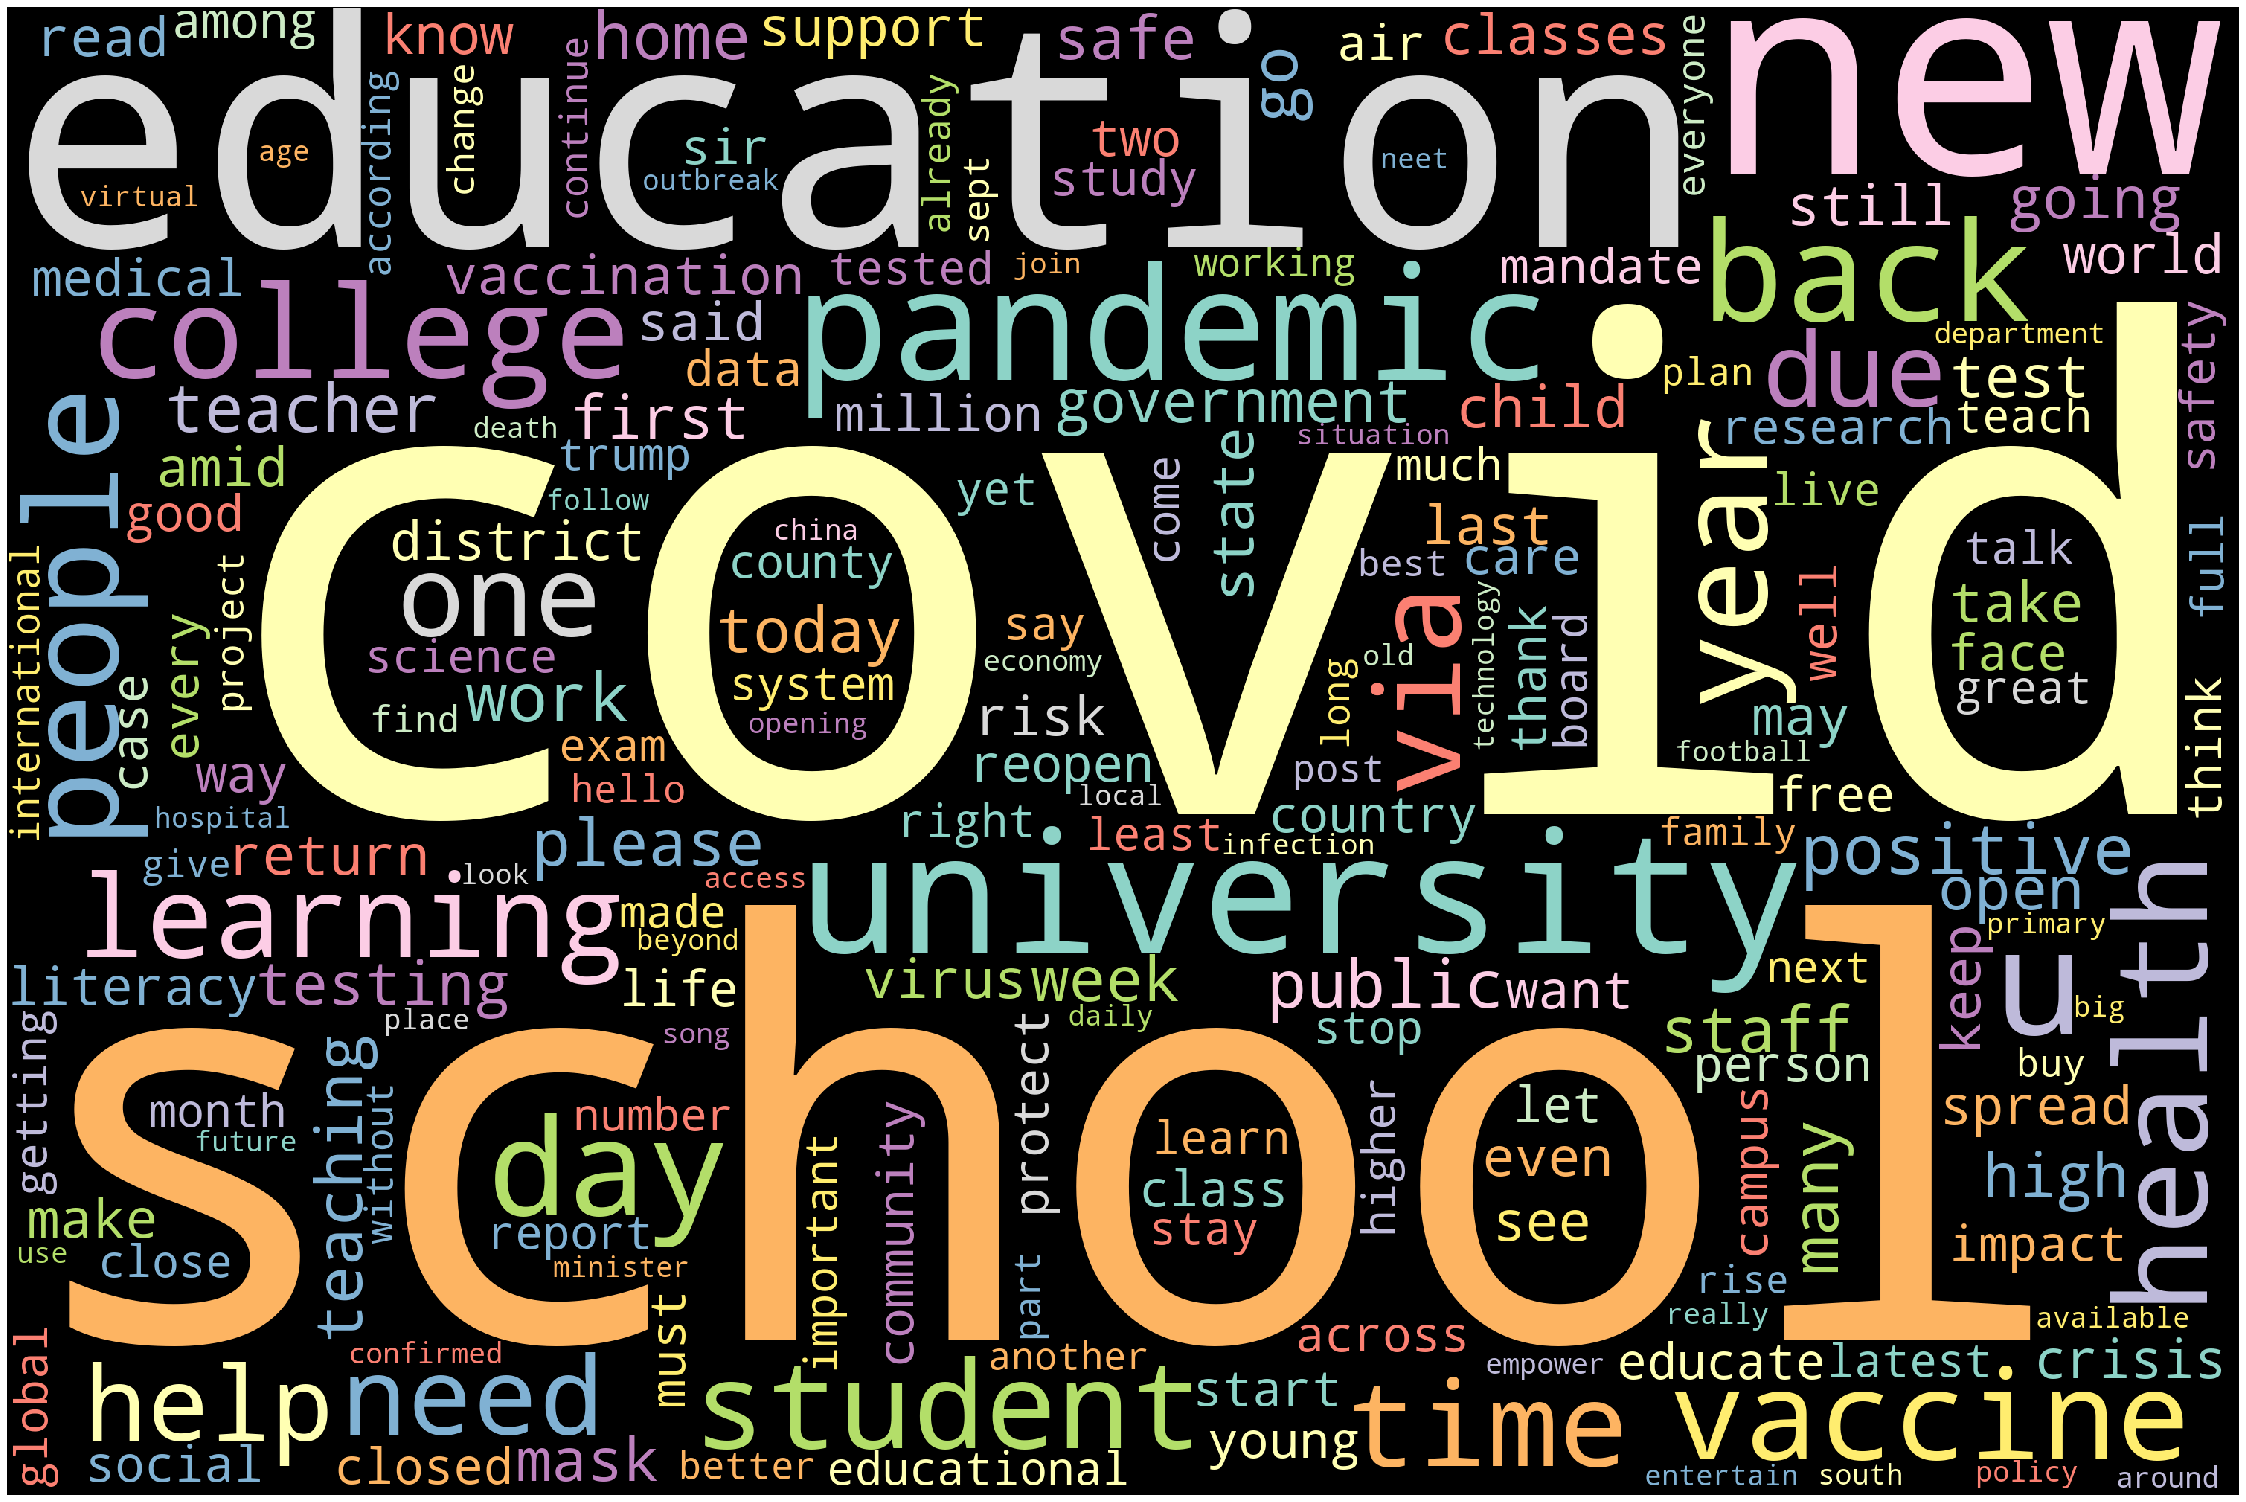

In [44]:
mainWordCloud = ''
for i in wordCloudByPeriod.values():
    mainWordCloud += " "+i+" "

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set3', collocations=False, stopwords = STOPWORDS).generate(mainWordCloud)
plot_cloud(wordcloud)

# Union and Intersection of Monthly Words 

In [46]:
#union and intersection of most common words across phases 

period1_topWords = {i[0] for i in wordsCounterByPeriod['period1'].most_common(25)}
period2_topWords = {i[0] for i in wordsCounterByPeriod['period2'].most_common(25)}
period3_topWords = {i[0] for i in wordsCounterByPeriod['period3'].most_common(25)}
period4_topWords = {i[0] for i in wordsCounterByPeriod['period4'].most_common(25)}
Union= set().union(period1_topWords, period2_topWords, period3_topWords, period4_topWords)
Intersect = period1_topWords.intersection(period2_topWords, period3_topWords, period4_topWords) 
print(Union, "\n", len(Union))
print(Intersect, "\n", len(Intersect))

{'college', 'may', 'please', 'first', 'staff', 'home', 'pandemic', 'us', 'public', 'health', 'go', 'new', 'year', 'recruitment', 'need', 'child', 'district', 'due', 'medical', 'vaccine', 'teacher', 'positive', 'day', 'learning', 'via', 'work', 'student', 'teaching', 'back', 'covid', 'mask', 'news', 'get', 'one', 'like', 'educational', 'higher', 'help', 'university', 'vaccination', 'education', 'time', 'school', 'people'} 
 44
{'college', 'learning', 'pandemic', 'us', 'get', 'student', 'one', 'health', 'university', 'back', 'education', 'new', 'school', 'people', 'covid'} 
 15


# Computing Cosine Similarity between Phases 

In [47]:
#reference: https://stackoverflow.com/questions/55162668/calculate-similarity-between-list-of-words
from collections import Counter
import math

def counter_cosine_similarity(c1, c2):
    counterA = Counter(c1)
    counterB = Counter(c2)
    terms = set(counterA).union(counterB)
    dotprod = sum(counterA.get(k, 0) * counterB.get(k, 0) for k in terms)
    magA = math.sqrt(sum(counterA.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(counterB.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)


In [543]:
##cosine sim between top words

periods_topWords = [period1_topWords,period2_topWords,period3_topWords,period4_topWords]
pairs = [(a, b) for idx, a in enumerate(periods_topWords) for b in periods_topWords[idx + 1:]] 
for pair in pairs: 
    print(counter_cosine_similarity(pair[0], pair[1]))

0.72
0.64
0.68
0.68
0.72
0.72


In [48]:
all_periods = pd.DataFrame.from_dict(wordsCounterByPeriod).sort_index(axis = 0)
all_periods = all_periods.fillna(0)
all_words = all_periods.index
all_words = sorted(list(all_words))

In [49]:
def cosine_similarity(u, v):
    sim = u.dot(v) / (np.linalg.norm(u) * np.linalg.norm(v))
    return sim 

In [51]:
all_periods = np.array(all_periods)
#period1 & 2
cosine_similarity(all_periods[:,0], all_periods[:,1])
#period2 & 3
cosine_similarity(all_periods[:,1], all_periods[:,2])
#period1 & 3
cosine_similarity(all_periods[:,0], all_periods[:,2])
#period1 & 4
cosine_similarity(all_periods[:,0], all_periods[:,3])
#period2 & 4
cosine_similarity(all_periods[:,1], all_periods[:,3])
#period3 & 4
cosine_similarity(all_periods[:,2], all_periods[:,3])

0.9411400586588498

# Sampling Tweets that contain certain keyword

In [61]:
def get_sample_tweets_with_timestamp(keyword, period): 
    sample_tweets_with_timestamp = []
    for i, token_list in enumerate(wordsByPeriod[period]): 
        if keyword in token_list: 
            sample_tweets_with_timestamp.append(tweets_with_time[period][i])
    with open(f'./data/{keyword}_tweets_sample_{period}_with_timestamp.csv', 'w', newline='') as f:
        writer=csv.writer(f)
        writer.writerows(sample_tweets_with_timestamp)         
    return sample_tweets_with_timestamp 

In [1]:
## example: sample Tweets containing the keyword "teacher" from each phase
get_sample_tweets_with_timestamp("teacher", "period1")
get_sample_tweets_with_timestamp("teacher", "period2")
get_sample_tweets_with_timestamp("teacher", "period3")
get_sample_tweets_with_timestamp("teacher", "period4")